In [66]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import torch
# from tqdm import tqdm
from torch_geometric.utils import to_networkx
import networkx as nx
from gnn import GNN
import matplotlib.pyplot as plt
import os
import numpy as np
from gnn import GNN
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch_geometric.data import Data, Batch
import plotly.express as px

In [67]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
loader = DataLoader(dataset, batch_size=64)
atom_indices = {
    0: "C",
    1: "N",
    2: "O",
    3: "F",
    4: "I",
    5: "Cl",
    6: "Br",
}

atom_colors = {
    0: "#9b5fe0",
    1: "#16a4d8",
    2: "#60dbe8",
    3: "#efdf48",
    4: "#f9a52c",
    5: "#d64e11",
    6: "#8bd346",
}

edge_indices = {
    0: "aromatic",
    1: "single",
    2: "double",
    3: "triple",
}

In [68]:
model_path = "models/MUTAG_model.pth"
nn = torch.load(model_path)
nn.eval()

GNN(
  (conv1): SAGEConv(7, 16, aggr=mean)
  (conv2): SAGEConv(16, 16, aggr=mean)
  (conv3): SAGEConv(16, 16, aggr=mean)
  (lin1): Linear(in_features=16, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=2, bias=True)
)

In [69]:
nn.float()
all_outputs = []
for data in loader:
    outputs = nn(data.x, data.edge_index, data.batch).detach().numpy()
    all_outputs.append(outputs)
all_outputs = np.concatenate(all_outputs, axis=0)
for i in range(all_outputs.shape[-1]):
    px.histogram(all_outputs[:, i], title=f"Class {i} Logit Distribution").show()

In [93]:
index = 1 #"Final"
A = np.load(f"./solutions/A_{index}.npy")
X = np.load(f"./solutions/X_{index}.npy")

In [94]:
X

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]])

[(0, 1), (0, 5), (2, 3), (3, 6), (4, 8), (7, 11), (9, 10)]


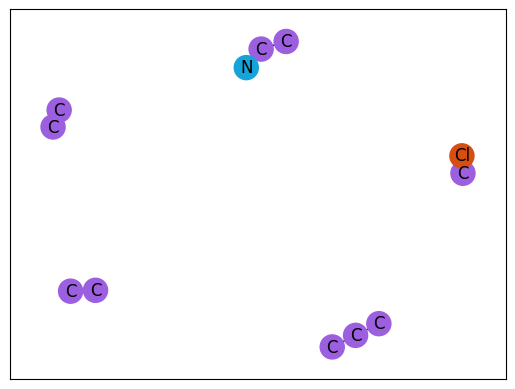

In [87]:
G = nx.from_numpy_array(A, create_using=nx.Graph)

print(G.edges)

labels = dict(zip(range(X.shape[0]), map(atom_indices.get, np.argmax(X, axis=1))))
fig, ax = plt.subplots()
pos = nx.spring_layout(G, seed=7)
x_indices = np.argmax(X, axis=1)
nx.draw_networkx(G, pos=pos, with_labels=True, labels=labels, node_color=list(map(atom_colors.get, x_indices)))


In [72]:
folder = "figures"
for i in range(31):
    A = np.load(f"./solutions/A_{i}.npy")
    X = np.load(f"./solutions/X_{i}.npy")
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)

    labels = dict(zip(range(X.shape[0]), map(atom_indices.get, np.argmax(X, axis=1))))
    fig, ax = plt.subplots()
    # pos = nx.circular_layout(G)
    pos = nx.spring_layout(G, seed=7)
    x_indices = np.argmax(X, axis=1)
    nx.draw_networkx(G, pos=pos, with_labels=True, labels=labels, node_color=list(map(atom_colors.get, x_indices)))

    
    plt.savefig(folder + "/file%02d.png" % i)
    plt.close()

# def generate_video(img):
#     for i in range(len(img)):
#         plt.imshow(img[i], cmap=cm.Greys_r)
#         plt.savefig(folder + "/file%02d.png" % i)

import subprocess
import glob
os.chdir(folder)
subprocess.call([
    'ffmpeg', '-framerate', '4', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p', '-y',
    'graph_steps.mp4'
])
for file_name in glob.glob("*.png"):
    os.remove(file_name)
os.chdir("..")

ffmpeg version 2.8.17-0ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.12) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvo

In [73]:
def to_batch(X, A):
    g = dict()
    g["edge_index"], g["edge_weight"] = dense_to_sparse(A)
    g["x"] = X
    return Batch.from_data_list([Data(**g)])

In [74]:
nn.double()

GNN(
  (conv1): SAGEConv(7, 16, aggr=mean)
  (conv2): SAGEConv(16, 16, aggr=mean)
  (conv3): SAGEConv(16, 16, aggr=mean)
  (lin1): Linear(in_features=16, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=2, bias=True)
)

In [75]:
batch = to_batch(torch.Tensor(X).double(), torch.Tensor(A.astype(int)))
print("NN output given X", nn.get_embedding_outputs(batch)[1].detach().numpy())

NN output given X [[133.17807002 -74.46044556]]
